## Regional Grain Size Model v2

Dan Buscombe 7/3/22

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from pingouin import partial_corr
import pingouin as pg
from sklearn.model_selection import RepeatedKFold, cross_val_score


In [2]:
bujan_dat = pd.read_csv('../../../orig_data/bujan_et_al_data/Size-Slope-Data-Points.csv')
bujan_dat#.keys()

bujan_sand = bujan_dat[bujan_dat['Clast size (mm)']<2]

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### load and filter model training /testing data

In [3]:
choice = 'transects'
merge = 'right'
dataset = '../model_data_out/ML_slope_wave_atlantic_2022-05-18_Data_Post2012_VerifiedOnshore_0.0015_right_transects.csv'
# dataset = 'ML_slope_wave_atlantic_2022-05-18_Data_Post2012_VerifiedOnshore_0.003_right_transects.csv'
# dataset = 'ML_slope_wave_atlantic_2022-05-18_Data_Post2012_VerifiedOnshore_0.001_right_transects.csv'

In [4]:
tmp = pd.read_csv(dataset)
ind = np.where(tmp['quality_flag_right']!='Low')[0]
len(ind)
tmp = tmp.iloc[ind]
len(tmp)

ind = np.where(tmp['quality_flag_left']!='Low')[0]
len(ind)
tmp = tmp.iloc[ind]
len(tmp)

4365

In [5]:
tmp.keys()

Index(['Unnamed: 0', 'hs_max', 'hs_mean', 'dir', 'tp', 'latitude_left',
       'latitude_left.1', 'longitude_left', 'longitude_left.1',
       'quality_flag_left', 'quality_flag_right', 'd50', 'width_ci_average',
       'beach_slope_average', 'beach_slope_median', 'sl_points_average',
       'mstr', 'prc_mstr_obs', 'min_tide_obs', 'max_tide_obs', 'site_id',
       'beach_slope', 'lower_conf_bound', 'upper_conf_bound', 'width_ci',
       'sl_points', 'trend', 'distance', 'latitude', 'longitude'],
      dtype='object')

In [6]:
df_strat_mstr = tmp.copy()

num_cats=8
num_samples_per_category = 15

df_strat_mstr['category'] = pd.cut(tmp['mstr'], num_cats)
df_strat_mstr = df_strat_mstr.groupby(['category']).apply(lambda x: x.sample(num_samples_per_category, replace = False)).reset_index(drop = True)

len(df_strat_mstr)

120

In [7]:
df_strat_beta = tmp.copy()

num_cats=13
num_samples_per_category = 15

df_strat_beta['category'] = pd.cut(tmp['beach_slope_median'], num_cats)
df_strat_beta = df_strat_beta.groupby(['category']).apply(lambda x: x.sample(num_samples_per_category, replace = False)).reset_index(drop = True)

len(df_strat_beta)

195

In [8]:
df_strat_lat = tmp.copy()

num_cats=18
num_samples_per_category = 15

df_strat_lat['category'] = pd.cut(tmp['latitude'], num_cats)
df_strat_lat = df_strat_lat.groupby(['category']).apply(lambda x: x.sample(num_samples_per_category, replace = False)).reset_index(drop = True)

len(df_strat_lat)

270

In [9]:
del tmp

### exploratory plots

In [10]:
df = df_strat_lat.copy()

Text(0.25, -78, '$R^2$=0.03')

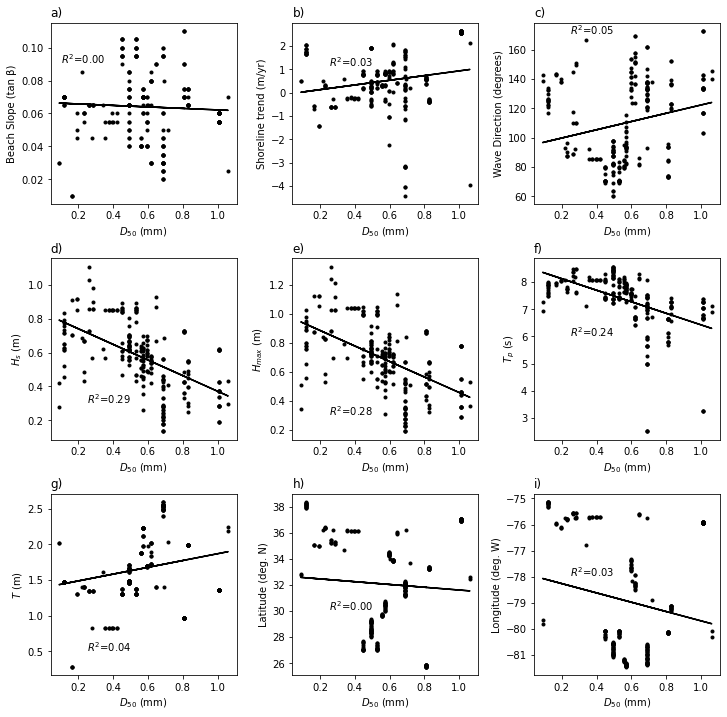

In [11]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(331)
plt.plot(df['d50'], df['beach_slope'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Beach Slope (tan β)')
plt.title("a)", loc='left')

coef = np.polyfit(df['d50'], df['beach_slope'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['beach_slope']))**2
plt.text(.1,.09,r'$R^2$='+str(r2)[:4])

plt.subplot(332)
plt.plot(df['d50'], df['trend'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Shoreline trend (m/yr)')
plt.title("b)", loc='left')

coef = np.polyfit(df['d50'], df['trend'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['trend']))**2
plt.text(.25,1.1,r'$R^2$='+str(r2)[:4])

plt.subplot(333)
plt.plot(df['d50'], df['dir'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Wave Direction (degrees)')
plt.title("c)", loc='left')

coef = np.polyfit(df['d50'], df['dir'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['dir']))**2
plt.text(.25,170,r'$R^2$='+str(r2)[:4])

plt.subplot(334)
plt.plot(df['d50'], df['hs_mean'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{s}$ (m)')
plt.title("d)", loc='left')

coef = np.polyfit(df['d50'], df['hs_mean'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['hs_mean']))**2
plt.text(.25,.3,r'$R^2$='+str(r2)[:4])

plt.subplot(335)
plt.plot(df['d50'], df['hs_max'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{max}$ (m)')
plt.title("e)", loc='left')

coef = np.polyfit(df['d50'], df['hs_max'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['hs_max']))**2
plt.text(.25,.3,r'$R^2$='+str(r2)[:4])

plt.subplot(336)
plt.plot(df['d50'], df['tp'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T_{p}$ (s)')
plt.title("f)", loc='left')

coef = np.polyfit(df['d50'], df['tp'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['tp']))**2
plt.text(.25,6,r'$R^2$='+str(r2)[:4])

plt.subplot(337)
plt.plot(df['d50'],df['mstr'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T$ (m)')
plt.title("g)", loc='left')

coef = np.polyfit(df['d50'], df['mstr'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['mstr']))**2
plt.text(.25,.5,r'$R^2$='+str(r2)[:4])

plt.subplot(338)
plt.plot(df['d50'],df['latitude'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Latitude (deg. N)')
plt.title("h)", loc='left')

coef = np.polyfit(df['d50'], df['latitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['latitude']))**2
plt.text(.25,30,r'$R^2$='+str(r2)[:4])

plt.subplot(339)
plt.plot(df['d50'],df['longitude'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Longitude (deg. W)')
plt.title("i)", loc='left')

coef = np.polyfit(df['d50'], df['longitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['longitude']))**2
plt.text(.25,-78,r'$R^2$='+str(r2)[:4])

# plt.savefig('data_plots/CGRASP_d50-linreg-df_strat_lat.jpg', dpi=300, bbox_inches='tight')

In [12]:
df = df_strat_beta.copy()

Text(0.25, -78, '$R^2$=0.33')

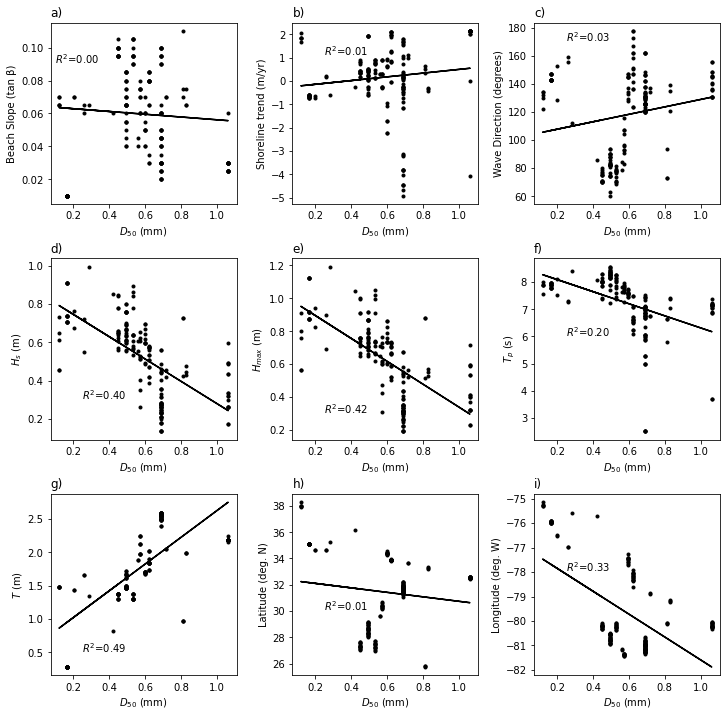

In [13]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(331)
plt.plot(df['d50'], df['beach_slope'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Beach Slope (tan β)')
plt.title("a)", loc='left')

coef = np.polyfit(df['d50'], df['beach_slope'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['beach_slope']))**2
plt.text(.1,.09,r'$R^2$='+str(r2)[:4])

plt.subplot(332)
plt.plot(df['d50'], df['trend'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Shoreline trend (m/yr)')
plt.title("b)", loc='left')

coef = np.polyfit(df['d50'], df['trend'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['trend']))**2
plt.text(.25,1.1,r'$R^2$='+str(r2)[:4])

plt.subplot(333)
plt.plot(df['d50'], df['dir'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Wave Direction (degrees)')
plt.title("c)", loc='left')

coef = np.polyfit(df['d50'], df['dir'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['dir']))**2
plt.text(.25,170,r'$R^2$='+str(r2)[:4])

plt.subplot(334)
plt.plot(df['d50'], df['hs_mean'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{s}$ (m)')
plt.title("d)", loc='left')

coef = np.polyfit(df['d50'], df['hs_mean'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['hs_mean']))**2
plt.text(.25,.3,r'$R^2$='+str(r2)[:4])

plt.subplot(335)
plt.plot(df['d50'], df['hs_max'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{max}$ (m)')
plt.title("e)", loc='left')

coef = np.polyfit(df['d50'], df['hs_max'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['hs_max']))**2
plt.text(.25,.3,r'$R^2$='+str(r2)[:4])

plt.subplot(336)
plt.plot(df['d50'], df['tp'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T_{p}$ (s)')
plt.title("f)", loc='left')

coef = np.polyfit(df['d50'], df['tp'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['tp']))**2
plt.text(.25,6,r'$R^2$='+str(r2)[:4])

plt.subplot(337)
plt.plot(df['d50'],df['mstr'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T$ (m)')
plt.title("g)", loc='left')

coef = np.polyfit(df['d50'], df['mstr'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['mstr']))**2
plt.text(.25,.5,r'$R^2$='+str(r2)[:4])

plt.subplot(338)
plt.plot(df['d50'],df['latitude'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Latitude (deg. N)')
plt.title("h)", loc='left')

coef = np.polyfit(df['d50'], df['latitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['latitude']))**2
plt.text(.25,30,r'$R^2$='+str(r2)[:4])

plt.subplot(339)
plt.plot(df['d50'],df['longitude'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Longitude (deg. W)')
plt.title("i)", loc='left')

coef = np.polyfit(df['d50'], df['longitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['longitude']))**2
plt.text(.25,-78,r'$R^2$='+str(r2)[:4])

# plt.savefig('data_plots/CGRASP_d50-linreg-df_strat_beta.jpg', dpi=300, bbox_inches='tight')

In [14]:
df = df_strat_mstr.copy()

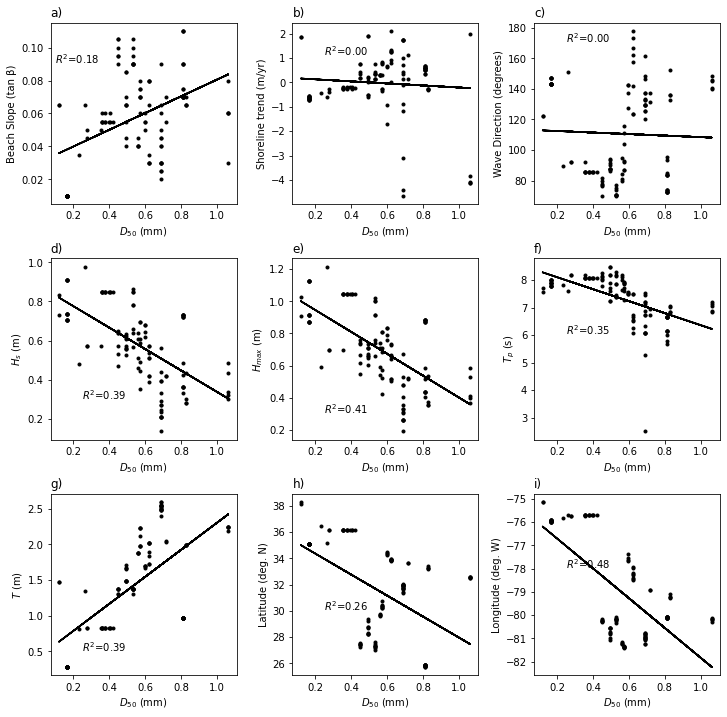

In [15]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(331)
plt.plot(df['d50'], df['beach_slope'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Beach Slope (tan β)')
plt.title("a)", loc='left')

coef = np.polyfit(df['d50'], df['beach_slope'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['beach_slope']))**2
plt.text(.1,.09,r'$R^2$='+str(r2)[:4])

plt.subplot(332)
plt.plot(df['d50'], df['trend'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Shoreline trend (m/yr)')
plt.title("b)", loc='left')

coef = np.polyfit(df['d50'], df['trend'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['trend']))**2
plt.text(.25,1.1,r'$R^2$='+str(r2)[:4])

plt.subplot(333)
plt.plot(df['d50'], df['dir'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Wave Direction (degrees)')
plt.title("c)", loc='left')

coef = np.polyfit(df['d50'], df['dir'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['dir']))**2
plt.text(.25,170,r'$R^2$='+str(r2)[:4])

plt.subplot(334)
plt.plot(df['d50'], df['hs_mean'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{s}$ (m)')
plt.title("d)", loc='left')

coef = np.polyfit(df['d50'], df['hs_mean'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['hs_mean']))**2
plt.text(.25,.3,r'$R^2$='+str(r2)[:4])

plt.subplot(335)
plt.plot(df['d50'], df['hs_max'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{max}$ (m)')
plt.title("e)", loc='left')

coef = np.polyfit(df['d50'], df['hs_max'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['hs_max']))**2
plt.text(.25,.3,r'$R^2$='+str(r2)[:4])

plt.subplot(336)
plt.plot(df['d50'], df['tp'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T_{p}$ (s)')
plt.title("f)", loc='left')

coef = np.polyfit(df['d50'], df['tp'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['tp']))**2
plt.text(.25,6,r'$R^2$='+str(r2)[:4])

plt.subplot(337)
plt.plot(df['d50'],df['mstr'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T$ (m)')
plt.title("g)", loc='left')

coef = np.polyfit(df['d50'], df['mstr'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['mstr']))**2
plt.text(.25,.5,r'$R^2$='+str(r2)[:4])

plt.subplot(338)
plt.plot(df['d50'],df['latitude'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Latitude (deg. N)')
plt.title("h)", loc='left')

coef = np.polyfit(df['d50'], df['latitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['latitude']))**2
plt.text(.25,30,r'$R^2$='+str(r2)[:4])

plt.subplot(339)
plt.plot(df['d50'],df['longitude'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Longitude (deg. W)')
plt.title("i)", loc='left')

coef = np.polyfit(df['d50'], df['longitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['longitude']))**2
plt.text(.25,-78,r'$R^2$='+str(r2)[:4])

plt.savefig('../data_plots/CGRASP_d50-linreg-df_strat_mstr.jpg', dpi=300, bbox_inches='tight')

In [16]:
def mcfall(X,hs):
    if hs<=1:
        A = 3.1; n = -1.1 
    elif hs>=3:
        A = 3.9; n = -1.85         
    else:
        A = 2.1; n = -1.8             
    return (X/A)**(1/n)

In [17]:
def prc_err(y,yest):
    return 100*(np.abs(y-yest)/y)

In [18]:
def bujan(B,a,b,c):
    t1=(B-c)
    return (1/8)*(8*((t1/a))**(1/b)+1)

### Model - data stratified by latitude

In [19]:
X = pg.pairwise_corr(df[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

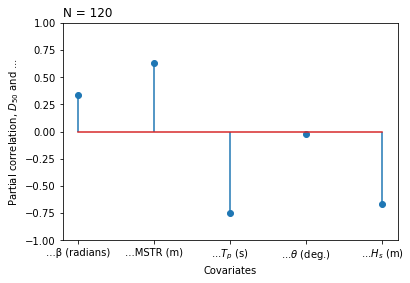

In [20]:

ax=plt.subplot(111)
plt.stem(X['r'])
# plt.stem(lower)
# plt.stem(upper)
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (radians)','...MSTR (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-1,1)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"N = {}".format(len(df)), loc='left')

plt.savefig('../data_plots/partial_correl_SEUS.jpg', dpi=300, bbox_inches='tight')

In [21]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 10,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

test_size = 0.75

In [22]:
Smean = []
Sstd = []

In [23]:
# rand = np.random.randn(len(df))
# np.save(dataset.replace('.csv','_rand.npy').replace('model_data_out','model_out'), rand, allow_pickle=True)

In [24]:
rand = np.load(dataset.replace('.csv','_rand.npy').replace('model_data_out','model_out'), allow_pickle=True)

In [25]:
feature_names1 = ['β (radians)', 'S (m/yr)', 'MSTR (m)', 'Random']
# X = np.stack((df['beach_slope_median'],df['trend'],df['mstr'], rand))
X = np.stack((df['beach_slope_average'],df['trend'],df['mstr'], rand))
# X = np.stack((df['beach_slope'],df['trend'],df['mstr'], rand))
X.shape

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model1 = ensemble.GradientBoostingRegressor(**params)
model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

The mean squared error (MSE) on test set: 0.0176


In [26]:
model1out = {}
model1out['feature_names'] = feature_names1
model1out['Xtest'] = X_test1
model1out['Xtrain'] = X_train1
model1out['ytest'] = y_test1
model1out['ytrain'] = y_train1
model1out['model'] = model1
model1out['mse'] = mse1

In [27]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model1, X_test1, y_test1, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.055 (0.031)


In [28]:
feature_names2 = [r'β (radians)','MSTR (m)', 'Random (non-dim.)']
# X = np.stack((df['beach_slope_median'],df['mstr'], rand))
X = np.stack((df['beach_slope_average'],df['mstr'], rand))
# X = np.stack((df['beach_slope'],df['mstr'], rand))
X.shape

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model2 = ensemble.GradientBoostingRegressor(**params)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

The mean squared error (MSE) on test set: 0.0251


In [29]:
model2out = {}
model2out['feature_names'] = feature_names2
model2out['Xtest'] = X_test2
model2out['Xtrain'] = X_train2
model2out['ytest'] = y_test2
model2out['ytrain'] = y_train2
model2out['model'] = model2
model2out['mse'] = mse2

In [30]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model2, X_test2, y_test2, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.041 (0.028)


In [31]:
feature_names3 = [r'$H_s$ (m)', r'$T_p$ (s)', r'$\theta$ (dir.)', 'Random (non-dim.)']
X = np.stack((df['hs_mean'],df['tp'],df['dir'], rand))
# X = np.stack((df['hs_max'],df['tp'],df['dir'], rand))
X.shape

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model3 = ensemble.GradientBoostingRegressor(**params)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

The mean squared error (MSE) on test set: 0.0205


In [32]:
model3out = {}
model3out['feature_names'] = feature_names3
model3out['Xtest'] = X_test3
model3out['Xtrain'] = X_train3
model3out['ytest'] = y_test3
model3out['ytrain'] = y_train3
model3out['model'] = model3
model3out['mse'] = mse3

In [33]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model3, X_test3, y_test3, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.111 (0.045)


In [34]:
feature_names4 = [r'$H_s$ (m)', r'$T_p$ (s)', r'$\theta$ (dir.)','MSTR (m)','β', 'Random (non-dim.)']
X = np.stack((df['hs_mean'],df['tp'],df['dir'],df['mstr'], df['beach_slope_average'], rand))
# X = np.stack((df['hs_max'],df['tp'],df['dir'],df['mstr'], rand))
X.shape

X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model4 = ensemble.GradientBoostingRegressor(**params)
model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

The mean squared error (MSE) on test set: 0.0153


In [35]:
model4out = {}
model4out['feature_names'] = feature_names4
model4out['Xtest'] = X_test4
model4out['Xtrain'] = X_train4
model4out['ytest'] = y_test4
model4out['ytrain'] = y_train4
model4out['model'] = model4
model4out['mse'] = mse4

In [36]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model4, X_test4, y_test4, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.084 (0.049)


In [37]:
feature_names5 = ['MSTR (m)', 'Random (non-dim.)']
X = np.stack((df['mstr'], rand))
X.shape

X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model5 = ensemble.GradientBoostingRegressor(**params)
model5.fit(X_train5, y_train5)

mse5 = mean_squared_error(y_test5, model5.predict(X_test5))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))

The mean squared error (MSE) on test set: 0.0248


In [38]:
model5out = {}
model5out['feature_names'] = feature_names5
model5out['Xtest'] = X_test5
model5out['Xtrain'] = X_train5
model5out['ytest'] = y_test5
model5out['ytrain'] = y_train5
model5out['model'] = model5
model5out['mse'] = mse5

In [39]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model5, X_test5, y_test5, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.065 (0.037)


In [40]:
feature_names6 = ['β (m)', 'Random (non-dim.)']
X = np.stack((df['beach_slope_average'], rand))
# X = np.stack((df['beach_slope_median'], rand))
X.shape

X_train6, X_test6, y_train6, y_test6 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model6 = ensemble.GradientBoostingRegressor(**params)
model6.fit(X_train6, y_train6)

mse6 = mean_squared_error(y_test6,model6.predict(X_test6))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

The mean squared error (MSE) on test set: 0.0385


In [41]:
model6out = {}
model6out['feature_names'] = feature_names6
model6out['Xtest'] = X_test6
model6out['Xtrain'] = X_train6
model6out['ytest'] = y_test6
model6out['ytrain'] = y_train6
model6out['model'] = model6
model6out['mse'] = mse6

In [42]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model6, X_test6, y_test6, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.112 (0.048)


In [43]:
Smean

[0.05508075800220522,
 0.04074661589271128,
 0.11088162136687758,
 0.08420966113181957,
 0.06499822079535603,
 0.11211823728381605]

In [44]:
ds_est_baseline = [mcfall(X,hs) for X,hs in zip(1/df['beach_slope'],df['hs_mean'])]

a = -0.154
b = -0.145
c = 0.268

ds_est_baseline2 = [bujan(B,a,b,c) for B in df['beach_slope']]

### model skill

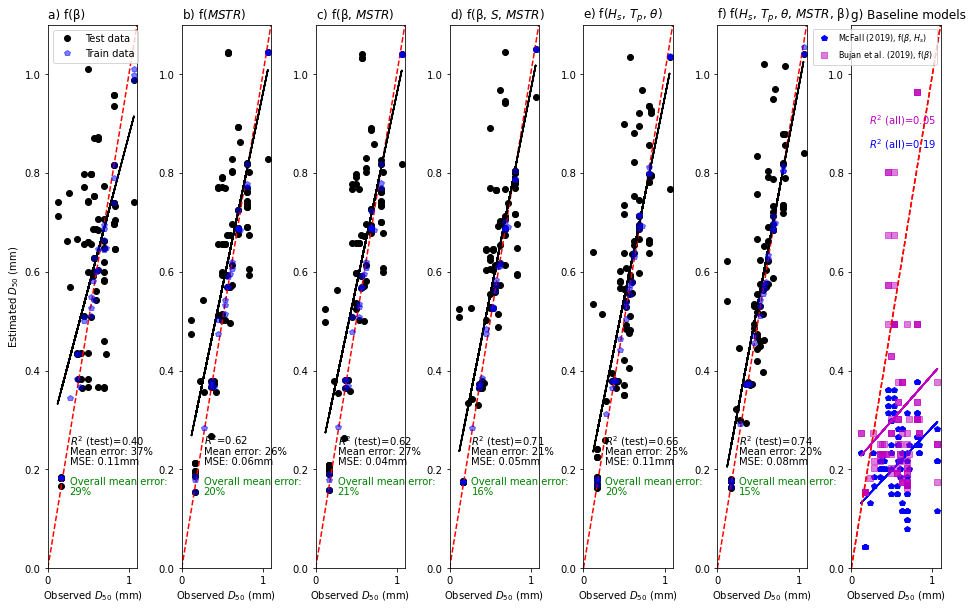

In [45]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.5, hspace=0.)

plt.subplot(171)
ds_est = model6.predict(X_test6)
plt.plot(y_test6, ds_est, 'ko', label='Test data')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) f(β)", loc='left')
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[5])[:4]))

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'bp', alpha=0.5, label='Train data')
plt.legend(loc=2)

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test6,y_train6)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(172)
ds_est = model5.predict(X_test5)
plt.plot(y_test5, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) f($MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test5, ds_est))**2
plt.text(.27,.25,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(y_test5, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test5, poly1d_fn(y_test5), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[4])[:4]))

ds_est2 = model5.predict(X_train5)
plt.plot(y_train5, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test5,y_train5)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(173)
ds_est = model2.predict(X_test2)
plt.plot(y_test2, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("c) f(β, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[1])[:4]))

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test2,y_train2)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(174)
ds_est = model1.predict(X_test1)
plt.plot(y_test1, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("d) f(β, $S$, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[0])[:4]))

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test1,y_train1)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(175)
ds_est = model3.predict(X_test3)
plt.plot(y_test3, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) f($H_s$, $T_p$, $\theta$)", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[2])[:4]))

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test3,y_train3)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(176)
ds_est = model4.predict(X_test4)
plt.plot(y_test4, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) f($H_s$, $T_p$, $\theta$, $MSTR$, β)", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[3])[:4]))

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test4,y_train4)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(177)
plt.plot(df['d50'], ds_est_baseline, 'bp', label=r'McFall (2019), f($\beta$, $H_s$)')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"g) Baseline models", loc='left')
r2 = np.min(np.corrcoef(df['d50'], ds_est_baseline))**2
plt.text(.22,.85,r'$R^2$ (all)='+str(r2)[:4], color='b')

coef = np.polyfit(df['d50'], ds_est_baseline,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-b')

# plt.subplot(326)
plt.plot(df['d50'], ds_est_baseline2, 'ms', alpha=0.5, label=r"Bujan et al. (2019), f($\beta$)")
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
# plt.title(r"f) Bujan et al. (2019) relation, f($\beta$)", loc='left')
r2 = np.min(np.corrcoef(df['d50'], ds_est_baseline2))**2
plt.text(.22,.9,r'$R^2$ (all)='+str(r2)[:4], color='m')

coef = np.polyfit(df['d50'], ds_est_baseline2,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-m')
plt.legend(fontsize=8)

plt.savefig('../model_plots/CGRASP_d50-6model-baseline-skill-CSabstract.jpg', dpi=300, bbox_inches='tight')
# plt.close()

### Model - data stratified by latitude

In [46]:
df = df_strat_lat.copy()

In [47]:
# tmp.to_csv(dataset.replace('.csv','_model_stratsample8.csv')) # 216 samples (no replacement)
# tmp = pd.read_csv(dataset.replace('.csv','_model_stratsample8.csv'))

In [48]:
del df['category']

In [49]:
df.to_csv(dataset.replace('.csv','_model_stratsample-by-lat.csv')) # 270 samples (no replacement)
df = pd.read_csv(dataset.replace('.csv','_model_stratsample-by-lat.csv'))

In [50]:
len(df)

270

In [51]:
X = pg.pairwise_corr(df[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

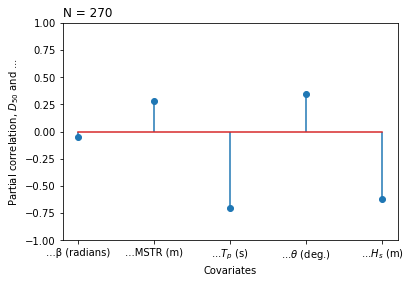

In [52]:

ax=plt.subplot(111)
plt.stem(X['r'])
# plt.stem(lower)
# plt.stem(upper)
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (radians)','...MSTR (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-1,1)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"N = {}".format(len(df)), loc='left')

plt.savefig('../data_plots/partial_correl_SEUS_stratlat.jpg', dpi=300, bbox_inches='tight')

In [53]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 10,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

test_size = 0.75

In [54]:
# rand = np.random.randn(len(df))
# np.save(dataset.replace('.csv','_rand_stratlat.npy').replace('model_data_out','model_out'), rand, allow_pickle=True)

In [55]:
rand = np.load(dataset.replace('.csv','_rand_stratlat.npy').replace('model_data_out','model_out'), allow_pickle=True)

In [56]:
feature_names1 = ['β (radians)', 'S (m/yr)', 'MSTR (m)', 'Random (non-dim.)']
# X = np.stack((df['beach_slope_median'],df['trend'],df['mstr'], rand))
X = np.stack((df['beach_slope_average'],df['trend'],df['mstr'], rand))
# X = np.stack((df['beach_slope'],df['trend'],df['mstr'], rand))
X.shape

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model1 = ensemble.GradientBoostingRegressor(**params)
model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

The mean squared error (MSE) on test set: 0.0113


In [57]:
model1out = {}
model1out['feature_names'] = feature_names1
model1out['Xtest'] = X_test1
model1out['Xtrain'] = X_train1
model1out['ytest'] = y_test1
model1out['ytrain'] = y_train1
model1out['model'] = model1
model1out['mse'] = mse1

In [58]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model1, X_test1, y_test1, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.057 (0.036)


In [59]:
feature_names2 = [r'β (radians)','MSTR (m)', 'Random (non-dim.)']
# X = np.stack((df['beach_slope_median'],df['mstr'], rand))
X = np.stack((df['beach_slope_average'],df['mstr'], rand))
# X = np.stack((df['beach_slope'],df['mstr'], rand))
X.shape

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model2 = ensemble.GradientBoostingRegressor(**params)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

The mean squared error (MSE) on test set: 0.0121


In [60]:
model2out = {}
model2out['feature_names'] = feature_names2
model2out['Xtest'] = X_test2
model2out['Xtrain'] = X_train2
model2out['ytest'] = y_test2
model2out['ytrain'] = y_train2
model2out['model'] = model2
model2out['mse'] = mse2

In [61]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model2, X_test2, y_test2, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.057 (0.046)


In [62]:
feature_names3 = [r'$H_s$ (m)', r'$T_p$ (s)', r'$\theta$ (dir.)', 'Random (non-dim.)']
X = np.stack((df['hs_mean'],df['tp'],df['dir'], rand))
# X = np.stack((df['hs_max'],df['tp'],df['dir'], rand))
X.shape

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model3 = ensemble.GradientBoostingRegressor(**params)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

The mean squared error (MSE) on test set: 0.0271


In [63]:
model3out = {}
model3out['feature_names'] = feature_names3
model3out['Xtest'] = X_test3
model3out['Xtrain'] = X_train3
model3out['ytest'] = y_test3
model3out['ytrain'] = y_train3
model3out['model'] = model3
model3out['mse'] = mse3

In [64]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model3, X_test3, y_test3, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.100 (0.037)


In [65]:
feature_names4 = [r'$H_s$ (m)', r'$T_p$ (s)', r'$\theta$ (dir.)','MSTR (m)','β', 'Random (non-dim.)']
X = np.stack((df['hs_mean'],df['tp'],df['dir'],df['mstr'], df['beach_slope_average'], rand))
# X = np.stack((df['hs_max'],df['tp'],df['dir'],df['mstr'], rand))
X.shape

X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model4 = ensemble.GradientBoostingRegressor(**params)
model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

The mean squared error (MSE) on test set: 0.0217


In [66]:
model4out = {}
model4out['feature_names'] = feature_names4
model4out['Xtest'] = X_test4
model4out['Xtrain'] = X_train4
model4out['ytest'] = y_test4
model4out['ytrain'] = y_train4
model4out['model'] = model4
model4out['mse'] = mse4

In [67]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model4, X_test4, y_test4, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.068 (0.050)


In [68]:
feature_names5 = ['MSTR (m)', 'Random (non-dim.)']
X = np.stack((df['mstr'], rand))
X.shape

X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model5 = ensemble.GradientBoostingRegressor(**params)
model5.fit(X_train5, y_train5)

mse5 = mean_squared_error(y_test5, model5.predict(X_test5))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))

The mean squared error (MSE) on test set: 0.0144


In [69]:
model5out = {}
model5out['feature_names'] = feature_names5
model5out['Xtest'] = X_test5
model5out['Xtrain'] = X_train5
model5out['ytest'] = y_test5
model5out['ytrain'] = y_train5
model5out['model'] = model5
model5out['mse'] = mse5

In [70]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model5, X_test5, y_test5, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.074 (0.035)


In [71]:
feature_names6 = ['β (m)', 'Random (non-dim.)']
X = np.stack((df['beach_slope_average'], rand))
# X = np.stack((df['beach_slope_median'], rand))
X.shape

X_train6, X_test6, y_train6, y_test6 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model6 = ensemble.GradientBoostingRegressor(**params)
model6.fit(X_train6, y_train6)

mse6 = mean_squared_error(y_test6,model6.predict(X_test6))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

The mean squared error (MSE) on test set: 0.0347


In [72]:
model6out = {}
model6out['feature_names'] = feature_names6
model6out['Xtest'] = X_test6
model6out['Xtrain'] = X_train6
model6out['ytest'] = y_test6
model6out['ytrain'] = y_train6
model6out['model'] = model6
model6out['mse'] = mse6

In [73]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model6, X_test6, y_test6, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.102 (0.032)


In [74]:
ds_est_baseline = [mcfall(X,hs) for X,hs in zip(1/df['beach_slope'],df['hs_mean'])]

a = -0.154
b = -0.145
c = 0.268

ds_est_baseline2 = [bujan(B,a,b,c) for B in df['beach_slope']]

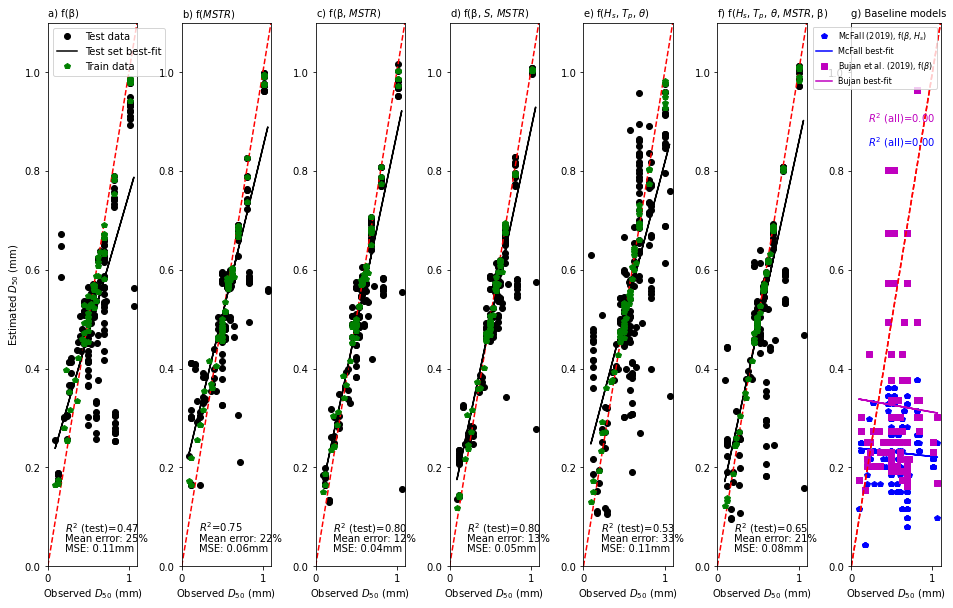

In [84]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.5, hspace=0.)

plt.subplot(171)
ds_est = model6.predict(X_test6)
plt.plot(y_test6, ds_est, 'ko', label='Test data')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) f(β)", loc='left', fontsize=10)
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.21,.07,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k', label='Test set best-fit')
plt.text(.21,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:2]))
plt.text(.21,.03, r'MSE: {}mm'.format(str(Smean[5])[:4]))

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'gp', label='Train data')
plt.legend(loc=2)

# plt.text(.27,.15, r'Overall mean error:', color='b')
# plt.text(.27,.13, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test6,y_train6)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(172)
ds_est = model5.predict(X_test5)
plt.plot(y_test5, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) f($MSTR$)", loc='left', fontsize=10)
r2 = np.min(np.corrcoef(y_test5, ds_est))**2
plt.text(.21,.07,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(y_test5, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test5, poly1d_fn(y_test5), '-k')
plt.text(.21,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
plt.text(.21,.03, r'MSE: {}mm'.format(str(Smean[4])[:4]))

ds_est2 = model5.predict(X_train5)
plt.plot(y_train5, ds_est2, 'gp', label='Train data')

# plt.text(.27,.15, r'Overall mean error:', color='b')
# plt.text(.27,.13, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test5,y_train5)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(173)
ds_est = model2.predict(X_test2)
plt.plot(y_test2, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("c) f(β, $MSTR$)", loc='left', fontsize=10)
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.21,.07,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')
plt.text(.21,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2,ds_est)))[:2]))
plt.text(.21,.03, r'MSE: {}mm'.format(str(Smean[1])[:4]))

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'gp',label='Train data')

# plt.text(.27,.15, r'Overall mean error:', color='b')
# plt.text(.27,.13, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test2,y_train2)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(174)
ds_est = model1.predict(X_test1)
plt.plot(y_test1, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("d) f(β, $S$, $MSTR$)", loc='left', fontsize=10)
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.21,.07,r'$R^2$ (test)='+str(r2)[:4])
plt.text(.21,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1,ds_est)))[:2]))
plt.text(.21,.03, r'MSE: {}mm'.format(str(Smean[0])[:4]))

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'gp', label='Train data')

# plt.text(.27,.15, r'Overall mean error:', color='b')
# plt.text(.27,.13, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test1,y_train1)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(175)
ds_est = model3.predict(X_test3)
plt.plot(y_test3, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) f($H_s$, $T_p$, $\theta$)", loc='left', fontsize=10)
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.21,.07,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
plt.text(.21,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:2]))
plt.text(.21,.03, r'MSE: {}mm'.format(str(Smean[2])[:4]))

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'gp',label='Train data')

# plt.text(.27,.15, r'Overall mean error:', color='b')
# plt.text(.27,.13, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test3,y_train3)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(176)
ds_est = model4.predict(X_test4)
plt.plot(y_test4, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) f($H_s$, $T_p$, $\theta$, $MSTR$, β)", loc='left', fontsize=10)
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.21,.07,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')
plt.text(.21,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:2]))
plt.text(.21,.03, r'MSE: {}mm'.format(str(Smean[3])[:4]))

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'gp', label='Train data')

# plt.text(.27,.15, r'Overall mean error:', color='b')
# plt.text(.27,.13, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test4,y_train4)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(177)
plt.plot(df['d50'], ds_est_baseline, 'bp', label=r'McFall (2019), f($\beta$, $H_s$)')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"g) Baseline models", loc='left', fontsize=10)
r2 = np.min(np.corrcoef(df['d50'], ds_est_baseline))**2
plt.text(.21,.85,r'$R^2$ (all)='+str(r2)[:4], color='b')

coef = np.polyfit(df['d50'], ds_est_baseline,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-b', label='McFall best-fit')

# plt.subplot(326)
plt.plot(df['d50'], ds_est_baseline2, 'ms', label=r"Bujan et al. (2019), f($\beta$)")
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
r2 = np.min(np.corrcoef(df['d50'], ds_est_baseline2))**2
plt.text(.21,.9,r'$R^2$ (all)='+str(r2)[:4], color='m')

coef = np.polyfit(df['d50'], ds_est_baseline2,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-m', label='Bujan best-fit')
plt.legend(fontsize=8)

plt.savefig('../model_plots/CGRASP_d50-6model-baseline-skill_stratlat-CSabstract.jpg', dpi=300, bbox_inches='tight')
# plt.close()

In [85]:
len(df)

270

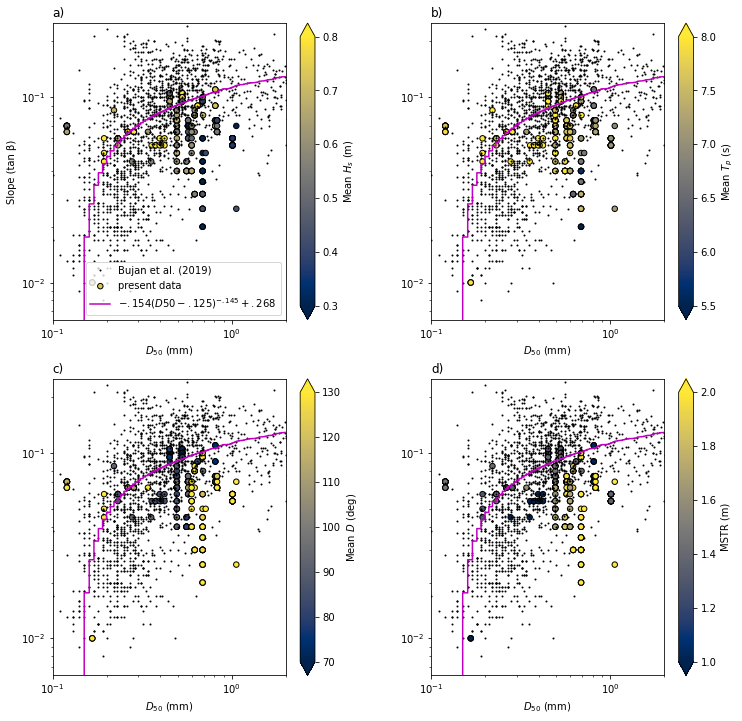

In [86]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

plt.subplot(221)

plt.loglog(bujan_dat['Clast size (mm)'], bujan_dat['Slope (tan β)'],'ko', markersize=1, label='Bujan et al. (2019)')
plt.scatter(df['d50'], df['beach_slope'],30,df['hs_mean'],label='present data', cmap='cividis', vmin=.3, vmax=.8, lw=1,edgecolors='black')

plt.xlabel(r'$D_{50}$ (mm)')

plt.ylabel('Slope (tan β)')
cb = plt.colorbar(extend='both')
plt.title("a)", loc='left')


cb.set_label(r'Mean $H_s$ (m)')

a = -0.154
b = -0.145
c = 0.268
ln = a*( bujan_dat['Clast size (mm)'] - 0.125)**b + c

plt.plot(np.sort(bujan_dat['Clast size (mm)']), np.sort(ln),'m', label=r'$-.154(D50 - .125)^{-.145} + .268$')

plt.xlim(0.1,2)
plt.ylim(10**-2.2,10**-.6)

plt.legend()

plt.subplot(222)
plt.loglog(bujan_dat['Clast size (mm)'], bujan_dat['Slope (tan β)'],'ko', markersize=1, label='Bujan et al. (2019)')
plt.scatter(df['d50'], df['beach_slope'],30,df['tp'],label='present data', cmap='cividis', vmin=5.5, vmax=8, lw=1,edgecolors='black')
plt.title("b)", loc='left')

plt.xlabel(r'$D_{50}$ (mm)')

# plt.ylabel('Slope (tan β)')
cb = plt.colorbar(extend='both')

cb.set_label(r'Mean $T_p$ (s)')

a = -0.154
b = -0.145
c = 0.268
ln = a*( bujan_dat['Clast size (mm)'] - 0.125)**b + c

plt.plot(np.sort(bujan_dat['Clast size (mm)']), np.sort(ln),'m', label=r'$-.154(D50 - .125)^{-.145} + .268$')

plt.xlim(0.1,2)
plt.ylim(10**-2.2,10**-.6)

plt.subplot(223)
plt.loglog(bujan_dat['Clast size (mm)'], bujan_dat['Slope (tan β)'],'ko', markersize=1, label='Bujan et al. (2019)')
plt.scatter(df['d50'], df['beach_slope'],30,df['dir'],label='Atlantic C-GRASP', cmap='cividis', vmin=70, vmax=130, lw=1,edgecolors='black')

plt.xlabel(r'$D_{50}$ (mm)')

# plt.ylabel('Slope (tan β)')
cb = plt.colorbar(extend='both')

cb.set_label(r'Mean $D$ (deg)')

a = -0.154
b = -0.145
c = 0.268
ln = a*( bujan_dat['Clast size (mm)'] - 0.125)**b + c

plt.plot(np.sort(bujan_dat['Clast size (mm)']), np.sort(ln),'m', label=r'$-.154(D50 - .125)^{-.145} + .268$')
plt.title("c)", loc='left')

plt.ylim(10**-2.2,10**-.6)
plt.xlim(0.1,2)


plt.subplot(224)
plt.loglog(bujan_dat['Clast size (mm)'], bujan_dat['Slope (tan β)'],'ko', markersize=1, label='Bujan et al. (2019)')
plt.scatter(df['d50'], df['beach_slope'],30,df['mstr'],label='Atlantic C-GRASP', cmap='cividis', vmin=1, vmax=2, lw=1,edgecolors='black')

plt.xlabel(r'$D_{50}$ (mm)')

# plt.ylabel('Slope (tan β)')
cb = plt.colorbar(extend='both')

cb.set_label(r'MSTR (m)')

a = -0.154
b = -0.145
c = 0.268
ln = a*( bujan_dat['Clast size (mm)'] - 0.125)**b + c

plt.plot(np.sort(bujan_dat['Clast size (mm)']), np.sort(ln),'m', label=r'$-.154(D50 - .125)^{-.145} + .268$')
plt.title("d)", loc='left')

plt.ylim(10**-2.2,10**-.6)
plt.xlim(0.1,2)

plt.savefig('../data_plots/CGRASP_d50-bujan-df_strat_lat.jpg', dpi=300, bbox_inches='tight')

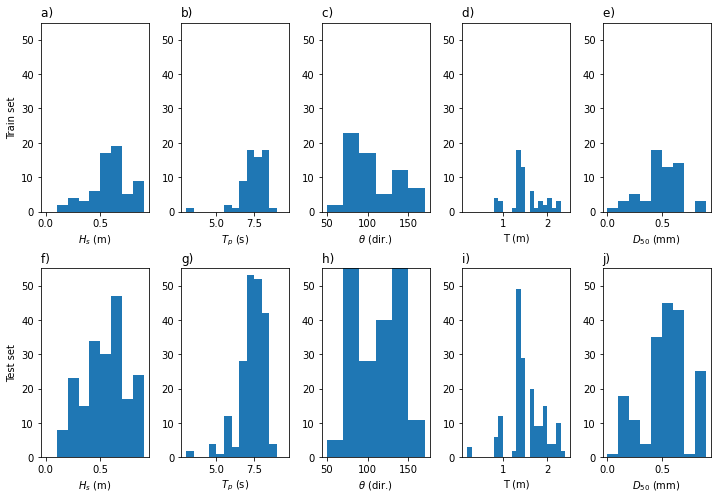

In [87]:
fig = plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(2,5,1)
plt.hist(X_train4[:,0], bins=np.arange(0,1,.1))
plt.ylim(0,55); plt.ylabel('Train set'); plt.xlabel(r'$H_s$ (m)')
plt.title(r'a) ', loc='left')

plt.subplot(2,5,2)
plt.hist(X_train4[:,1], bins=np.arange(3,10,.5))
plt.ylim(0,55); plt.xlabel(r'$T_p$ (s)')
plt.title(r'b)', loc='left')

plt.subplot(2,5,3)
plt.hist(X_train4[:,2], bins=np.arange(50,180,20))
plt.ylim(0,55); plt.xlabel(r'$\theta$ (dir.)')
plt.title(r'c) ', loc='left')

plt.subplot(2,5,4)
plt.hist(X_train4[:,3], bins=np.arange(0.2,2.5,.1))
plt.ylim(0,55); plt.xlabel('T (m)')
plt.title(r'd) ', loc='left')

plt.subplot(2,5,5)
plt.hist(y_train4, bins=np.arange(0,1,.1))
plt.ylim(0,55); plt.xlabel(r'$D_{50}$ (mm)')
plt.title(r'e) ', loc='left')

plt.subplot(2,5,6)
plt.hist(X_test4[:,0], bins=np.arange(0,1,.1))
plt.ylim(0,55); plt.ylabel('Test set'); plt.xlabel(r'$H_s$ (m)')
plt.title(r'f) ', loc='left')

plt.subplot(2,5,7)
plt.hist(X_test4[:,1], bins=np.arange(3,10,.5))
plt.ylim(0,55); plt.xlabel(r'$T_p$ (s)')
plt.title(r'g)', loc='left')

plt.subplot(2,5,8)
plt.hist(X_test4[:,2], bins=np.arange(50,180,20))
plt.ylim(0,55); plt.xlabel(r'$\theta$ (dir.)')
plt.title(r'h) ', loc='left')

plt.subplot(2,5,9)
plt.hist(X_test4[:,3], bins=np.arange(0.2,2.5,.1))
plt.ylim(0,55); plt.xlabel('T (m)')
plt.title(r'i) ', loc='left')

plt.subplot(2,5,10)
plt.hist(y_test4, bins=np.arange(0,1,.1))
plt.ylim(0,55); plt.xlabel('$D_{50}$ (mm)')
plt.title(r'j) ', loc='left')

plt.savefig('../data_plots/CGRASP_d50-test_train_dists.jpg', dpi=300, bbox_inches='tight')

### model training

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation

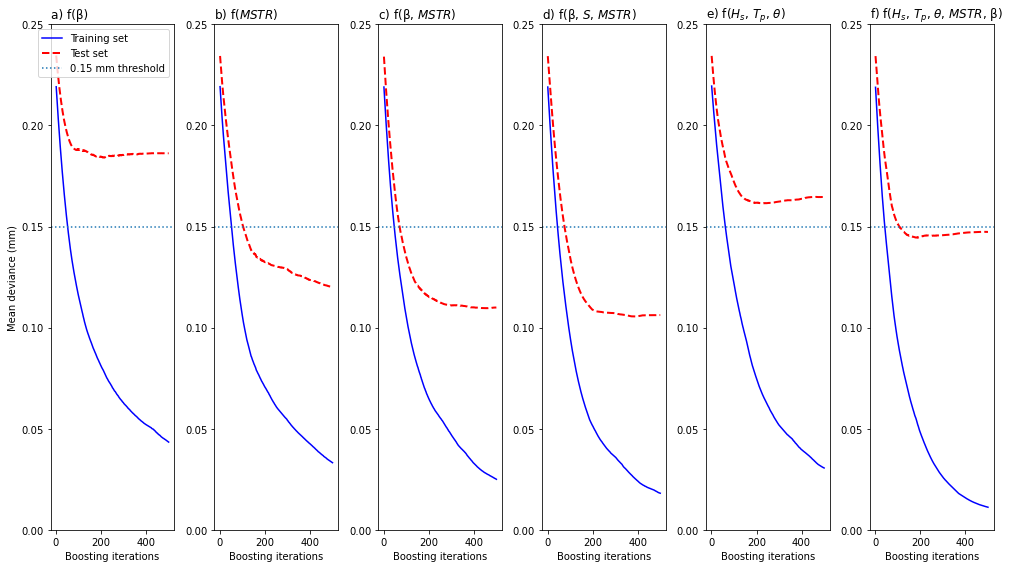

In [88]:
fig=plt.figure(figsize=(14,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)


####################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred6 in enumerate(model6.staged_predict(X_test6)):
    test_score[i] = model6.loss_(y_test6, y_pred6)

plt.subplot(1, 6, 1)
plt.title(r"a) f(β)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model6.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (mm)")
plt.ylim(0,.25)
plt.legend(loc="upper right")

###########################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred5 in enumerate(model5.staged_predict(X_test5)):
    test_score[i] = model5.loss_(y_test5, y_pred5)

plt.subplot(1, 6, 2)
plt.title(r"b) f($MSTR$)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model5.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)


#############################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred2 in enumerate(model2.staged_predict(X_test2)):
    test_score[i] = model2.loss_(y_test2, y_pred2)

plt.subplot(1, 6, 3)
plt.title("c) f(β, $MSTR$)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model2.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)


#####################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred1 in enumerate(model1.staged_predict(X_test1)):
    test_score[i] = model1.loss_(y_test1, y_pred1)
    
plt.subplot(1, 6, 4)
plt.title("d) f(β, $S$, $MSTR$) ", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model1.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)

#####################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred3 in enumerate(model3.staged_predict(X_test3)):
    test_score[i] = model3.loss_(y_test3, y_pred3)
    
plt.subplot(1, 6, 5)
plt.title(r"e) f($H_s$, $T_p$, $\theta$)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model3.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)

#####################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred4 in enumerate(model4.staged_predict(X_test4)):
    test_score[i] = model4.loss_(y_test4, y_pred4)
    
plt.subplot(1, 6, 6)
plt.title(r"f) f($H_s$, $T_p$, $\theta$, $MSTR$, β)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model4.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)

fig.tight_layout()
# plt.show()
plt.savefig('../model_plots/CGRASP_d50-4models-training-strat-lat.jpg', dpi=300, bbox_inches='tight')

### Feature importances

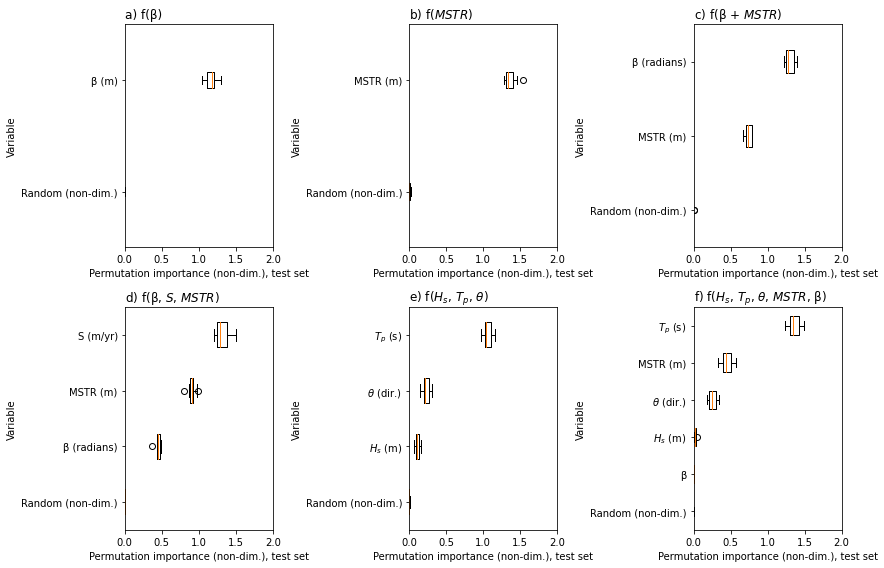

In [89]:

fig=plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

########################
result = permutation_importance(
    model6, X_test6, y_test6, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(231)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names6)[sorted_idx],
)

plt.xlim(0,2)
plt.title("a) f(β) ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
plt.ylabel("Variable")

#########################
result = permutation_importance(
    model5, X_test5, y_test5, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(232)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names5)[sorted_idx],
)

plt.xlim(0,2)
plt.title("b) f($MSTR$) ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
plt.ylabel("Variable")

#############################
result = permutation_importance(
    model2, X_test2, y_test3, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(233)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names2)[sorted_idx],
)

plt.xlim(0,2)
plt.title("c) f(β + $MSTR$) ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
plt.ylabel("Variable")

############################
result = permutation_importance(
    model1, X_test1, y_test1, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(234)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names1)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"d) f(β, $S$, $MSTR$)", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
plt.ylabel("Variable")

############################
result = permutation_importance(
    model3, X_test3, y_test3, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(235)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names3)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"e) f($H_s$, $T_p$, $\theta$) ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
plt.ylabel("Variable")

##################################
result = permutation_importance(
    model4, X_test4, y_test4, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(236)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names4)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"f) f($H_s$, $T_p$, $\theta$, $MSTR$, β) ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
plt.ylabel("Variable")

fig.tight_layout()

plt.savefig('../model_plots/CGRASP_d50-4models-featimps-v2.jpg', dpi=300, bbox_inches='tight')


In [90]:
X = pg.pairwise_corr(df[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

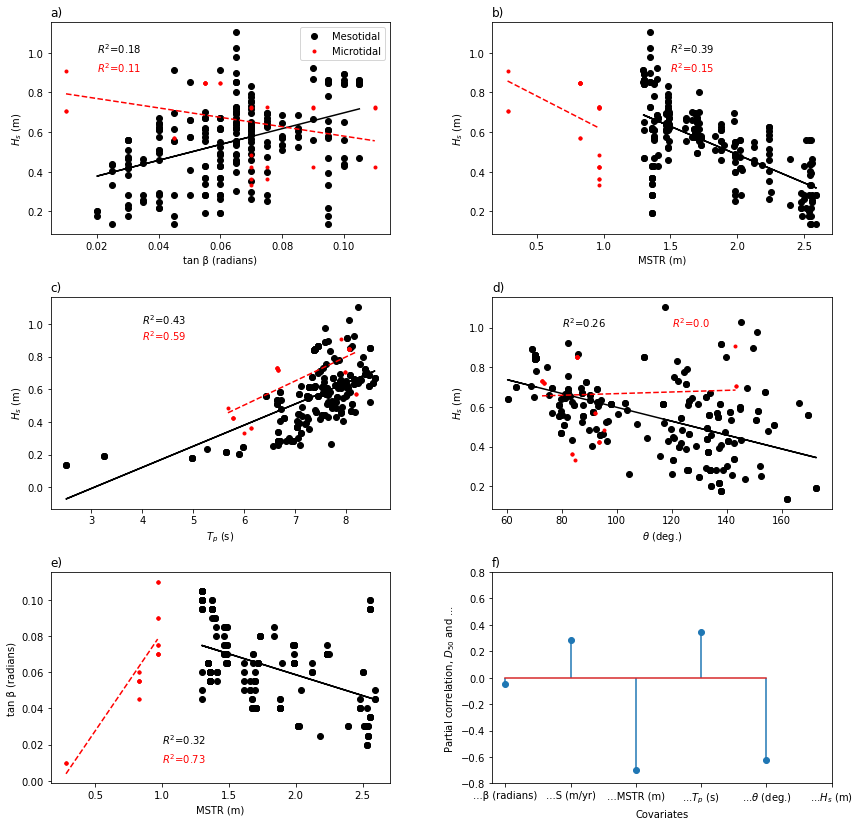

In [91]:
plt.figure(figsize=(14,14))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#=================================
# plt.subplot(331)
plt.subplot(321)
plt.plot(df['beach_slope'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],'ko', label='Mesotidal')
plt.plot(df['beach_slope'][df['mstr']<1],df['hs_mean'][df['mstr']<1],'r.', label='Microtidal')

coef = np.polyfit(df['beach_slope'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['beach_slope'][df['mstr']>=1], poly1d_fn(df['beach_slope'][df['mstr']>=1]), '-k')

coef = np.polyfit(df['beach_slope'][df['mstr']<1],df['hs_mean'][df['mstr']<1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(sorted(df['beach_slope'][df['mstr']<1]), poly1d_fn(sorted(df['beach_slope'][df['mstr']<1])), '--r')

r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']>=1], df['beach_slope'][df['mstr']>=1]))**2
plt.text(.02,1,r'$R^2$='+str(r2)[:4])

r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']<1], df['beach_slope'][df['mstr']<1]))**2
plt.text(.02,.9,r'$R^2$='+str(r2)[:4], color='r')

plt.ylabel(r'$H_s$ (m)')
plt.xlabel(r'tan β (radians)')
plt.title(r"a)", loc='left')
plt.legend()

#================================
# plt.subplot(332)
plt.subplot(322)
plt.plot(df['mstr'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],'ko')
plt.plot(df['mstr'][df['mstr']<1],df['hs_mean'][df['mstr']<1],'r.')

coef = np.polyfit(df['mstr'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['mstr'][df['mstr']>=1], poly1d_fn(df['mstr'][df['mstr']>=1]), '-k')

coef = np.polyfit(df['mstr'][df['mstr']<1],df['hs_mean'][df['mstr']<1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(sorted(df['mstr'][df['mstr']<1]), poly1d_fn(sorted(df['mstr'][df['mstr']<1])), '--r')

r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']>=1], df['mstr'][df['mstr']>=1]))**2
plt.text(1.5,1,r'$R^2$='+str(r2)[:4])

r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']<1], df['mstr'][df['mstr']<1]))**2
plt.text(1.5,.9,r'$R^2$='+str(r2)[:4], color='r')

plt.ylabel(r'$H_s$ (m)')
plt.xlabel(r'MSTR (m)')
plt.title(r"b)", loc='left')

#=================================
# plt.subplot(334)
plt.subplot(323)
plt.plot(df['tp'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],'ko')
plt.plot(df['tp'][df['mstr']<1],df['hs_mean'][df['mstr']<1],'r.')

coef = np.polyfit(df['tp'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['tp'][df['mstr']>=1], poly1d_fn(df['tp'][df['mstr']>=1]), '-k')

coef = np.polyfit(df['tp'][df['mstr']<1],df['hs_mean'][df['mstr']<1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(sorted(df['tp'][df['mstr']<1]), poly1d_fn(sorted(df['tp'][df['mstr']<1])), '--r')

r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']>=1], df['tp'][df['mstr']>=1]))**2
plt.text(4,1,r'$R^2$='+str(r2)[:4])

r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']<1], df['tp'][df['mstr']<1]))**2
plt.text(4,.9,r'$R^2$='+str(r2)[:4], color='r')

plt.ylabel(r'$H_s$ (m)')
plt.xlabel(r'$T_p$ (s)')
plt.title(r"c)", loc='left')

#=================================
# plt.subplot(335)
plt.subplot(324)
plt.plot(df['dir'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],'ko')
plt.plot(df['dir'][df['mstr']<1],df['hs_mean'][df['mstr']<1],'r.')

coef = np.polyfit(df['dir'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['dir'][df['mstr']>=1], poly1d_fn(df['dir'][df['mstr']>=1]), '-k')

coef = np.polyfit(df['dir'][df['mstr']<1],df['hs_mean'][df['mstr']<1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(sorted(df['dir'][df['mstr']<1]), poly1d_fn(sorted(df['dir'][df['mstr']<1])), '--r')

r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']>=1], df['dir'][df['mstr']>=1]))**2
plt.text(80,1,r'$R^2$='+str(r2)[:4])

r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']<1], df['dir'][df['mstr']<1]))**2
plt.text(120,1,r'$R^2$=0.0', color='r') #+str(r2)[:4]

plt.ylabel(r'$H_s$ (m)')
plt.xlabel(r'$\theta$ (deg.)')
plt.title(r"d)", loc='left')

#=================================
# plt.subplot(233)
plt.subplot(325)
plt.plot(df['mstr'][df['mstr']>=1],df['beach_slope'][df['mstr']>=1],'ko')
plt.plot(df['mstr'][df['mstr']<1],df['beach_slope'][df['mstr']<1],'r.')

coef = np.polyfit(df['mstr'][df['mstr']>=1],df['beach_slope'][df['mstr']>=1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['mstr'][df['mstr']>=1], poly1d_fn(df['mstr'][df['mstr']>=1]), '-k')

coef = np.polyfit(df['mstr'][df['mstr']<1],df['beach_slope'][df['mstr']<1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(sorted(df['mstr'][df['mstr']<1]), poly1d_fn(sorted(df['mstr'][df['mstr']<1])), '--r')

r2 = np.min(np.corrcoef(df['beach_slope'][df['mstr']>=1], df['mstr'][df['mstr']>=1]))**2
plt.text(1,0.02,r'$R^2$='+str(.1+r2)[:4])

r2 = np.min(np.corrcoef(df['beach_slope'][df['mstr']<1], df['mstr'][df['mstr']<1]))**2
plt.text(1,0.01,r'$R^2$='+str(r2)[:4], color='r')

plt.ylabel(r'tan β (radians)')
plt.xlabel(r'MSTR (m)')
plt.title(r"e)", loc='left')

#=================================
ax=plt.subplot(326)
plt.stem(X['r'])
# plt.stem(lower)
# plt.stem(upper)
plt.xticks([0,1,2,3,4,5])
ax.set_xticklabels(['...β (radians)','...S (m/yr)', '...MSTR (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-.8,.8)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"f)", loc='left')

plt.savefig('../data_plots/multicol_plus_partial_correl-strat-lat.jpg', dpi=300, bbox_inches='tight')

### Save model

In [92]:
np.save(dataset.replace('.csv','_model1.npy').replace('model_data_out','model_out'), model1out, allow_pickle=True)
np.save(dataset.replace('.csv','_model2.npy').replace('model_data_out','model_out'), model2out, allow_pickle=True)
np.save(dataset.replace('.csv','_model3.npy').replace('model_data_out','model_out'), model3out, allow_pickle=True)
np.save(dataset.replace('.csv','_model4.npy').replace('model_data_out','model_out'), model4out, allow_pickle=True)
np.save(dataset.replace('.csv','_model5.npy').replace('model_data_out','model_out'), model5out, allow_pickle=True)
np.save(dataset.replace('.csv','_model6.npy').replace('model_data_out','model_out'), model6out, allow_pickle=True)

In [94]:
# import xgboost as xgb

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [95]:
# params = {
#     'n_estimators':500, 
#     'max_depth':4, 
#     'eta':0.01,  ##lr
#     'subsample':1.0, 
#     'colsample_bytree':1.0
# }

In [96]:
# model1 = xgb.XGBRegressor(**params)
# model1.fit(X_train1, y_train1)
# mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
# print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

The mean squared error (MSE) on test set: 0.0242


In [97]:
# model2 = xgb.XGBRegressor(**params)
# model2.fit(X_train2, y_train2)
# mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
# print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

The mean squared error (MSE) on test set: 0.0135


In [98]:
# model3 = xgb.XGBRegressor(**params)
# model3.fit(X_train3, y_train3)
# mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
# print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

The mean squared error (MSE) on test set: 0.0364


In [99]:
# model4 = xgb.XGBRegressor(**params)
# model4.fit(X_train4, y_train4)
# mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
# print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

The mean squared error (MSE) on test set: 0.0236


In [102]:
# model5 = xgb.XGBRegressor(**params)
# model5.fit(X_train5, y_train5)
# mse5 = mean_squared_error(y_test5, model5.predict(X_test5))
# print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))

The mean squared error (MSE) on test set: 0.0244


In [669]:
# plt.figure(figsize=(12,12))
# plt.subplots_adjust(wspace=0.2, hspace=0.4)

# plt.subplot(321)
# ds_est = model1.predict(X_test1)
# plt.plot(y_test1, ds_est, 'ko')
# plt.xlim(0,1.1); plt.ylim(0,1.1)
# yl=plt.ylim()
# plt.plot(yl,yl,'--r')
# plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
# plt.title("a) β + $S$ + $T$ model", loc='left')
# r2 = np.min(np.corrcoef(y_test1, ds_est))**2
# plt.text(.22,.85,r'$R^2$='+str(r2)[:4])
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1,ds_est)))[:5]))

# coef = np.polyfit(y_test1, ds_est,1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(y_test1, poly1d_fn(y_test1), '-k')

# plt.subplot(322)
# ds_est = model2.predict(X_test2)
# plt.plot(y_test2, ds_est, 'ko')
# plt.xlim(0,1.1); plt.ylim(0,1.1)
# yl=plt.ylim()
# plt.plot(yl,yl,'--r')
# plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
# plt.title("b) β + $T$ model", loc='left')
# r2 = np.min(np.corrcoef(y_test2, ds_est))**2
# plt.text(.22,.85,r'$R^2$='+str(r2)[:4])

# coef = np.polyfit(y_test2, ds_est,1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(y_test2, poly1d_fn(y_test2), '-k')
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2,ds_est)))[:5]))

# plt.subplot(323)
# ds_est = model3.predict(X_test3)
# plt.plot(y_test3, ds_est, 'ko')
# plt.xlim(0,1.1); plt.ylim(0,1.1)
# yl=plt.ylim()
# plt.plot(yl,yl,'--r')
# plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
# plt.title(r"c) $H_s$ + $T_p$ + $\theta$ model", loc='left')
# r2 = np.min(np.corrcoef(y_test3, ds_est))**2
# plt.text(.22,.85,r'$R^2$='+str(r2)[:4])

# coef = np.polyfit(y_test3, ds_est,1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(y_test3, poly1d_fn(y_test3), '-k')
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:5]))


# plt.subplot(324)
# ds_est = model4.predict(X_test4)
# plt.plot(y_test4, ds_est, 'ko')
# plt.xlim(0,1.1); plt.ylim(0,1.1)
# yl=plt.ylim()
# plt.plot(yl,yl,'--r')
# plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
# plt.title(r"d) $H_s$ + $T_p$ + $\theta$ + $T$ model", loc='left')
# r2 = np.min(np.corrcoef(y_test4, ds_est))**2
# plt.text(.22,.85,r'$R^2$='+str(r2)[:4])

# coef = np.polyfit(y_test4, ds_est,1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(y_test4, poly1d_fn(y_test4), '-k')
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:5]))


# plt.subplot(325)
# ds_est = model5.predict(X_test5)
# plt.plot(y_test5, ds_est, 'ko')
# plt.xlim(0,1.1); plt.ylim(0,1.1)
# yl=plt.ylim()
# plt.plot(yl,yl,'--r')
# plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
# plt.title(r"e) $T$ model", loc='left')
# r2 = np.min(np.corrcoef(y_test5, ds_est))**2
# plt.text(.22,.85,r'$R^2$='+str(r2)[:4])

# coef = np.polyfit(y_test5, ds_est,1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(y_test5, poly1d_fn(y_test5), '-k')
# plt.text(.22,.95, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:5]))


# plt.subplot(326)
# plt.plot(tmp['d50'], ds_est_baseline, 'ko', label=r'McFall (2019), f($\beta$, $H_s$)')
# plt.xlim(0,1.1); plt.ylim(0,1.1)
# yl=plt.ylim()
# plt.plot(yl,yl,'--r')
# plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
# plt.title(r"f) Baselines", loc='left')
# r2 = np.min(np.corrcoef(tmp['d50'], ds_est_baseline))**2
# plt.text(.22,.6,r'$R^2$='+str(r2)[:4])

# coef = np.polyfit(tmp['d50'], ds_est_baseline,1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(tmp['d50'], poly1d_fn(tmp['d50']), '-k')


# # plt.subplot(326)
# plt.plot(tmp['d50'], ds_est_baseline2, 'rs', alpha=0.5, label=r"Bujan et al. (2019), f($\beta$)")
# plt.xlim(0,1.1); plt.ylim(0,1.1)
# yl=plt.ylim()
# plt.plot(yl,yl,'--r')
# plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
# # plt.title(r"f) Bujan et al. (2019) relation, f($\beta$)", loc='left')
# r2 = np.min(np.corrcoef(tmp['d50'], ds_est_baseline2))**2
# plt.text(.22,.5,r'$R^2$='+str(r2)[:4], color='r')

# coef = np.polyfit(tmp['d50'], ds_est_baseline2,1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(tmp['d50'], poly1d_fn(tmp['d50']), '-k')
# plt.legend()

# plt.savefig('model_plots/CGRASP_d50-6-XGBOOST-models-1:1.jpg', dpi=300, bbox_inches='tight')
# # plt.close()

In [1092]:
# # extract the x and y coordinates as flat arrays
# # x = np.ravel(grid['latitude'].values)
# # y = np.ravel(grid['longitude'].values)

# x,y = np.meshgrid(grid['latitude'].values, grid['longitude'].values)

# x = np.ravel(x)
# y = np.ravel(y)
# d = np.ravel(grid['d50 (mm)'].values)

# print(x.shape)
# print(d.shape)

# # using the X and Y columns, build a dataframe, then the geodataframe
# df1 = pd.DataFrame({'X':x, 'Y':y, 'D':d})
# df1['coords'] = list(zip(df1['X'], df1['Y']))
# df1['coords'] = df1['coords'].apply(Point)
# gdf1 = gpd.GeoDataFrame(df1, geometry='coords')